# Set Up

### import, config, sparksession, table reading

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, hex, base64, avg, collect_list, concat, lit, mean
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType
import pyspark.sql.functions as F 


In [6]:
#config for our sparksession
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '12g'), 
    ('spark.executor.cores', '2'), 
    ('spark.cores.max', '4'),
    ('spark.driver.memory','2g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '1'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1'),
    ('spark.worker.cleanup.enabled', 'true'),
    ('spark.worker.cleanup.interval', '60'),
    ('spark.shuffle.service.db.enabled', 'true'),
    ('spark.worker.cleanup.appDataTtl', '60'),
    ('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:10.0.2')
])

In [7]:
#create sparksession
#when copying change appName
spark = SparkSession \
    .builder \
    .config(conf=config) \
    .appName("3_BalanceDistribution") \
    .master("spark://172.23.149.212:7077") \
    .getOrCreate()

81742404 [Thread-4] WARN  org.apache.spark.util.Utils  - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
81742415 [Thread-4] WARN  org.apache.spark.util.Utils  - Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
81743440 [Thread-4] WARN  org.apache.spark.ExecutorAllocationManager  - Dynamic allocation without a shuffle service is an experimental feature.


In [8]:
# account table to determine which accounts have the highest balances
dfAccounts = spark.read.format("mongodb") \
    .option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
    .option('spark.mongodb.database', 'algorand') \
    .option('spark.mongodb.collection', 'account') \
    .option('park.mongodb.read.readPreference.name', 'primaryPreferred') \
    .option('spark.mongodb.change.stream.publish.full.document.only','true') \
    .option("forceDeleteTempCheckpointLocation", "true") \
    .load()


# Organizing Table

In [9]:
# drop all unneccessary columns
dfAccounts = dfAccounts.drop("_id","rewardsbase", "account_data", "rewards_total", "deleted", "closed_at", "keytype")

# calculate hom many algos are on the chain, and print the amount of algos on the chain
    
totalAlgos = dfAccounts.agg(F.sum("microalgos")).collect()[0][0]


#add column and calculate the proportion of the account to all algos, proportion is in %
dfAccounts = dfAccounts.withColumn("proportion", dfAccounts.microalgos/totalAlgos*100)

totalAccounts = dfAccounts.count()


### Write the Result in a Gold Table

In [6]:
newestRound = dfAccounts.agg(F.max("created_at")).collect()[0][0]

In [7]:
#write amount of Algos in gold table
#first put value in a df
result = spark.createDataFrame(
    [
        (totalAlgos, totalAlgos/1000, totalAccounts, newestRound)  # create your data here, be consistent in the types.
        
    ],
    ["TotalMicroAlgos", "TotalAlgos", "TotalAccounts", "CreationRound"]  # add your column names here
)

result.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("append") \
    .option('spark.mongodb.database', 'algorand_gold') \
  	.option('spark.mongodb.collection', 'TotalAlgos_3') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()


22/07/08 11:45:50 WARN CaseInsensitiveStringMap: Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.


In this table all addresses in the Algroand network are represented. The addresses are sorted by their account balance, starting with the largest one. In the last column their account balance is counterposed to the total amounts of Algos in the network. Therefore a centralisation of assets could be distinguished with this table.

# Plotting Balance Distribution

### Preparation

In [10]:
#everything with 0
dataWith0Accounts = dfAccounts.select("microalgos")

#write it back for metabase dashboard
dataWith0Accounts.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("overwrite") \
    .option('spark.mongodb.database', 'algorand_silver') \
  	.option('spark.mongodb.collection', 'Distribution_AccountBalances_incl_0_3') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()

#preparation for graph
dataWith0Accounts = dataWith0Accounts.collect()

#convert row["data"] to only data
microalgos0 = [row[0] for (row) in dataWith0Accounts]
mean_alg0 = dfAccounts.agg(F.mean("microalgos")).collect()[0][0]

81903488 [Thread-4] WARN  org.apache.spark.sql.util.CaseInsensitiveStringMap  - Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.


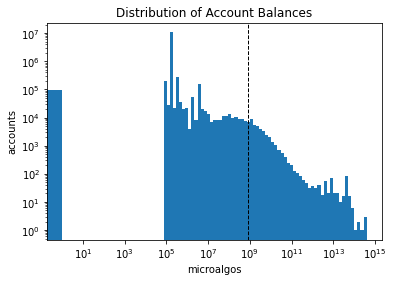

In [11]:
#histogram with all accounts
#how many bars in the histogram should be plotted
#histogram
bin_size = 50
#plus one so no 0 value is created
mybins = np.logspace(0, np.log10(max(microalgos0)), bin_size )
mybins = np.insert(mybins, 0, 0)

plt.figure()
plt.hist(microalgos0, bins = mybins)
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Microalgos")
plt.ylabel("Number of Accounts")
plt.title("Distribution of Account Balances", loc ='center', pad = None)
plt.axvline(mean_alg0, color='k', linestyle='dashed', linewidth=1)
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_AccountBalances_incl_0.jpg', dpi= 200)
plt.show()
plt.close()

In [12]:
#cell with no 0 values
#get rid off 0 values because they aredestroying the plot
dfAccNoZero = dfAccounts.filter(dfAccounts.microalgos > 0)

#graph
dataWithout0Accounts = dfAccNoZero.select("microalgos")

#preparation for graph
dataWithout0Accounts = dataWithout0Accounts.collect()

#convert row["data"] to only data
microalgos = [row[0] for (row) in dataWithout0Accounts]

#calculate the mean of all accounts with a balance > 0
mean_alg = dfAccNoZero.agg(F.mean("microalgos")).collect()[0][0]

83472294 [dispatcher-event-loop-8] ERROR org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend  - Application has been killed. Reason: Master removed our application: KILLED
83472338 [dispatcher-event-loop-8] ERROR org.apache.spark.rpc.netty.Inbox  - Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:919)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:154)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:262)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:169)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#histogram with all accounts with an amount > 0
#how many bars in the histogram should be plotted
#histogram
bin_size = 50
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(min(microalgos)), np.log10(max(microalgos)), bin_size )

plt.figure()
plt.hist(microalgos, bins = mybins)
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Microalgos")
plt.ylabel("Number of Accounts")
plt.title("Distribution of Account Balances > 0 ", loc ='center', pad = None)
plt.axvline(mean_alg, color='k', linestyle='dashed', linewidth=1)
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_AccountBalances_excl_0.jpg', dpi= 200)
plt.show()
plt.close()

In [12]:
#graph select only account balances, sort it from highest to lowest and take the highest 10 balances
whalesData = dfAccounts.select("microalgos", "addr").sort(col("microalgos").desc()).head(10)

#preparation for graph
#convert row["data"] to only data /1000 to reach algos from microalgos
whales = [row[0]/1000 for (row) in whalesData]
whalesAddresses = [row[1] for (row) in whalesData]


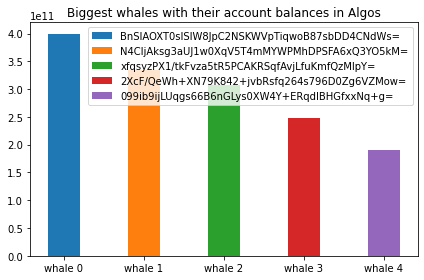

In [14]:
#save the whales, the top 10 whales are saved in a list
#the top 10 are plotted
name = "whale "
plt.figure()
for i in range(5):
    plt.bar(name + str(i), whales[i], width = 0.4)

plt.rcParams["figure.figsize"] = (10, 5)
plt.title("5 Biggest Whales with their Account Balances in Algos", loc ='center', pad = None)

plt.legend([whalesAddresses[0], whalesAddresses[1], whalesAddresses[2],whalesAddresses[3],whalesAddresses[4]])
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_whales.jpg', dpi= 200)
plt.show()
plt.close()

In [ ]:
#write the current whales in gold table
column = ["Addresses", "Algos"]
result = spark.createDataFrame(zip(whalesAddresses, whales), column)

#write it back for metabase dashboard
result.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("overwrite") \
    .option('spark.mongodb.database', 'algorand_gold') \
  	.option('spark.mongodb.collection', 'Distribution_whales_3') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()

In [4]:
spark.stop()